<a href="https://colab.research.google.com/github/Olesia2288/Hackathons/blob/main/%D0%A2%D0%B5%D1%82%D1%80%D0%B0%D0%B4%D1%8C_%D0%B4%D0%BB%D1%8F_%D1%81%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B9_%D0%AF%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B6%D0%B0%D0%BD%D1%80%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [1]:
# Устанавливаем необходимые библиотеки
!pip install phik
!pip install gdown
!pip install wordcloud
!pip install scikit-multilearn
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
import numpy as np
import optuna
import catboost
import nltk
import re

# Импортируем библиотеку для монтирования Google Диска
from google.colab import drive

from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import defaultdict
from skmultilearn.model_selection import iterative_train_test_split # для обработки несбалансированных классов
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Описание проекта

Вы сотрудник Отдела Data Science популярного музыкального
стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми
артистами и музыкантами, в связи с чем возникла задача -- правильно
классифицировать новые музыкальные треки, чтобы улучшить работу
рекомендательной системы.

**Цель проекта:** разработать модель, позволяющую классифицировать
музыкальные произведения по жанрам.

**Исходные данные:**
- train.csv - информация (~20000) музыкальных треках, которые будут
использоваться в качестве обучающих данных.
- test.csv - информация (~5000) музыкальных треках, которые будут использоваться
в качестве тестовых данных.
- sample_submit.csv - файл предсказаний в правильном формате.
- instance_id - идентификатор трека в тестовом наборе.
- music_genre - целевой признак. Для каждого трека предскажите категориальное
значение соответствующее музыкальному жанру трека.

# Загрузка и ознакомление с данными

Монтируем Google Диск:

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/датасет.zip'

Распакуем архив:

In [5]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [6]:
train_data = pd.read_csv('/content/ñáΓáßÑΓ/kaggle_music_genre_train.csv')
test_data = pd.read_csv('/content/ñáΓáßÑΓ/kaggle_music_genre_test.csv')

Посмотрим на обучающие данные:

In [7]:
train_data.head(10)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
5,43934.0,Eskimo Blue Day - Remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
6,23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,Rock
7,28380.0,Para Machuchar Meu Coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,Jazz
8,70054.0,In the Mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,Jazz
9,74815.0,20.000 Volts,0.032300,0.537,237000.0,0.962,0.193000,C,0.1580,-2.749,Major,0.1210,160.031,4-Apr,0.430,Electronic


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

**Описание полей данных:**
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- music_genre - музыкальный жанр

# Исследовательский анализ данных (EDA)

## Пропуски в данных

Посчитаем количество пропусков в исходных обучающих данных:

In [9]:
train_data.isnull().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [10]:
train_data.isnull().sum().sum()

1683

Всего пропущено 1683 значения. Это значения в столбцах key, mode и tempo. Из информации о датасете мы можем видеть, что key, mode - это категориальные переменные, а темп - чесловая переменная.

## Дубликаты


Проверим наличие дубликатов в обучающем датасете:

In [11]:
duplicates = train_data[train_data.duplicated()]

if duplicates.empty:
    print("Дубликатов в filled_train_data не найдено.")
else:
    print("Найдены дубликаты в filled_train_data.")
    print(duplicates.head())

Дубликатов в filled_train_data не найдено.


## Распределение целевого признака

Создадим датасет для наглядного отображения треков по жанрам:

In [12]:
genre_counts = train_data['music_genre'].value_counts()

In [13]:
genre_percentages = (genre_counts / len(train_data)) * 100

In [14]:
genre_distribution = pd.DataFrame({'Жанр': genre_counts.index, 'Количество': genre_counts.values, 'Процент': genre_percentages.values})

In [15]:
genre_distribution

,Жанр,Количество,Процент
0,Blues,2858,14.013926
1,Alternative,2601,12.753751
2,Electronic,2564,12.572325
3,Rap,2428,11.905462
4,Rock,2165,10.615867
5,Country,2120,10.395214
6,Anime,1901,9.321369
7,Classical,1373,6.732372
8,Jazz,1239,6.075316
9,Hip-Hop,1145,5.614396


Визуализируем полученный датасет с помощью столбчатой диаграммы:

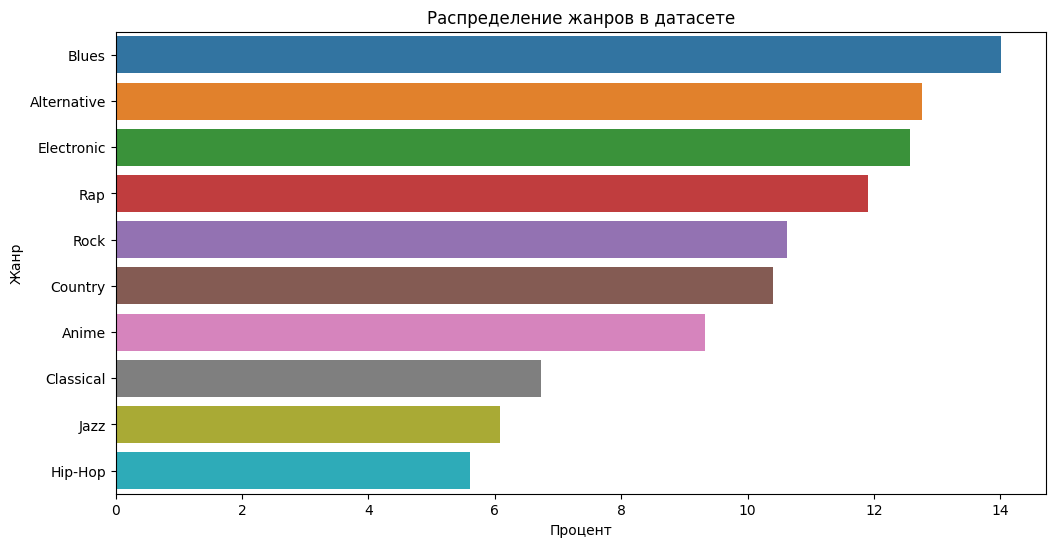

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Процент', y='Жанр', data=genre_distribution)
plt.xlabel('Процент')
plt.ylabel('Жанр')
plt.title('Распределение жанров в датасете')
plt.show()

 Всего в датасете представлено 10 различных жанров. Самыми многочисленными оказались треки в жанре блюз - 14% от обучающих данных, меньше всего треков в жанре хип-хоп - 5,6%.

## Статистические характеристики датасета

In [17]:
train_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


Явная аномалия - отрицательное значение в длительности трека. Удалять эти строки не следует, так как данных не очень много. Можно попробовать заменить медианным значением соответсвующего жанра.

Посмотрим на boxplot для каждого признака:

In [18]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

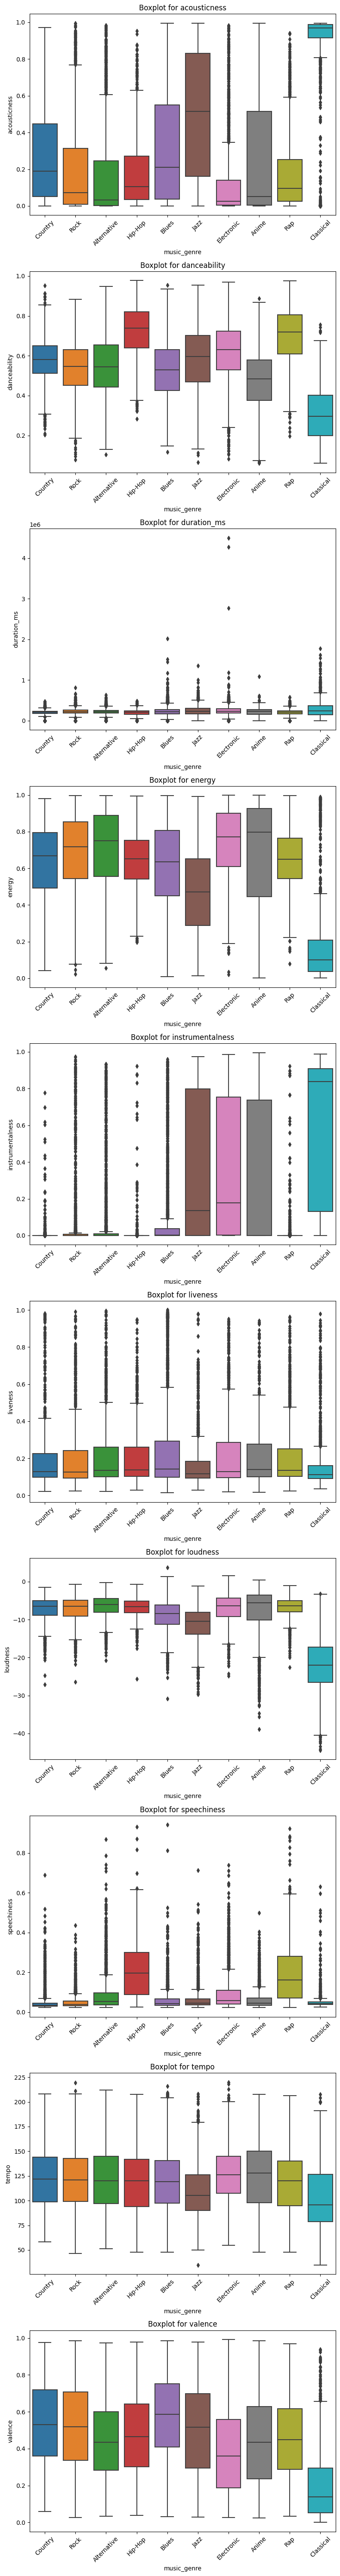

In [19]:
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 6 * len(features)))

for i, feature in enumerate(features):
    sns.boxplot(data=train_data, x='music_genre', y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot for {feature}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

- Акустика: такие жанры как блюз, джаз, аниме и кантри не имеют выбросов, следовательно, их акустические параметры более стабильны их легче предсказать. Классическая музыка, наоборот имеет наибольшее количество выбросов, что говорит о широком разбросе акустических диапазонов в этом жанре. Хип-хоп и рэп имеют очень схожие акустические диапазоны, с ними могут возникнуть сложности идентификации жанра между собой.

- Танцевальность: этот признак более устойчив, чем предыдущий. Графики практически не имеют выбросов, каждый жанр имеет свой уникальный диапазон танцевальности, особенно на фоне других жанров выделяется классика.

- Длительность: по этому признаку медианное значение одинаково почти для всех жанров. Есть выбросы в классической музыке, блюзе, джазе, таким образом в этих жанрах чаще встречаются более длинные треки. Также следует попробовать удалить все треки длинной более 5 минут (300000 мс).

- Энергичность: возможно один из важнейших признаков, так как каждому жанру свойственен свой диапазон, причем практически отсутствуют выбросы, статистические особенности жанров стабильны. Исключением является классическая музыка, которая имеет много шумов в данных, что еще раз подтверждает, что именно этот жанр будет тяжело предсказать.

- Инструментальность: этот признак особенно полезен для жанров - джаз, классика, анимэ, электроника. Для остальных жанров этот признак может быть не значителен, определенного диапазона, где бы находилось 75% данных, у прочих жанров нет, очень много выбросов.

- Живость: медианное значение у всех жанров практически одинаковое, визуально все графики похожи, много выбросов. Этот признак может вызвать ошибки модели.

- Громкость: уникальные диапазоны имеют жанры - блюз, джаз и классика, остальные жанры опять в этом признаке схожи.

- Выразительность: для многих жанров схожа, например для альтернативы и электроники, хип-хопа и рэпа, блюза и джаза, кантри и классики. Много выбросов.

- Темп: по этому признаку отличаются джаз и классика, остальные жанры по темпу очень похожи между собой, выбросы практически отсутсвуют. В жанре джаз есть одинн трек с аномально низким темпом, удалим его на стадии EDA:

In [20]:
train_data.drop(train_data[(train_data['music_genre'] == 'Jazz') & (train_data['tempo'] < 40)].index, inplace=True)

- Привлекательность для пользователя: также один из важных признаков. У всех жанров свой диапазон привлекательности и свои уникальные значения, выбросов нет, кроме жанра классики, что еще раз подтверждает теорию о разнообразии и сложности в предсказании такой музыки.

## Анализ категориальных признаков

Мы рассмотрели числовые признаки, осталось рассмотреть как влияют на распределение жанров дата загрузки в сервис, модальность и базовый ключ:

Визуализируем распределение значений в столбце 'key' по жанрам:

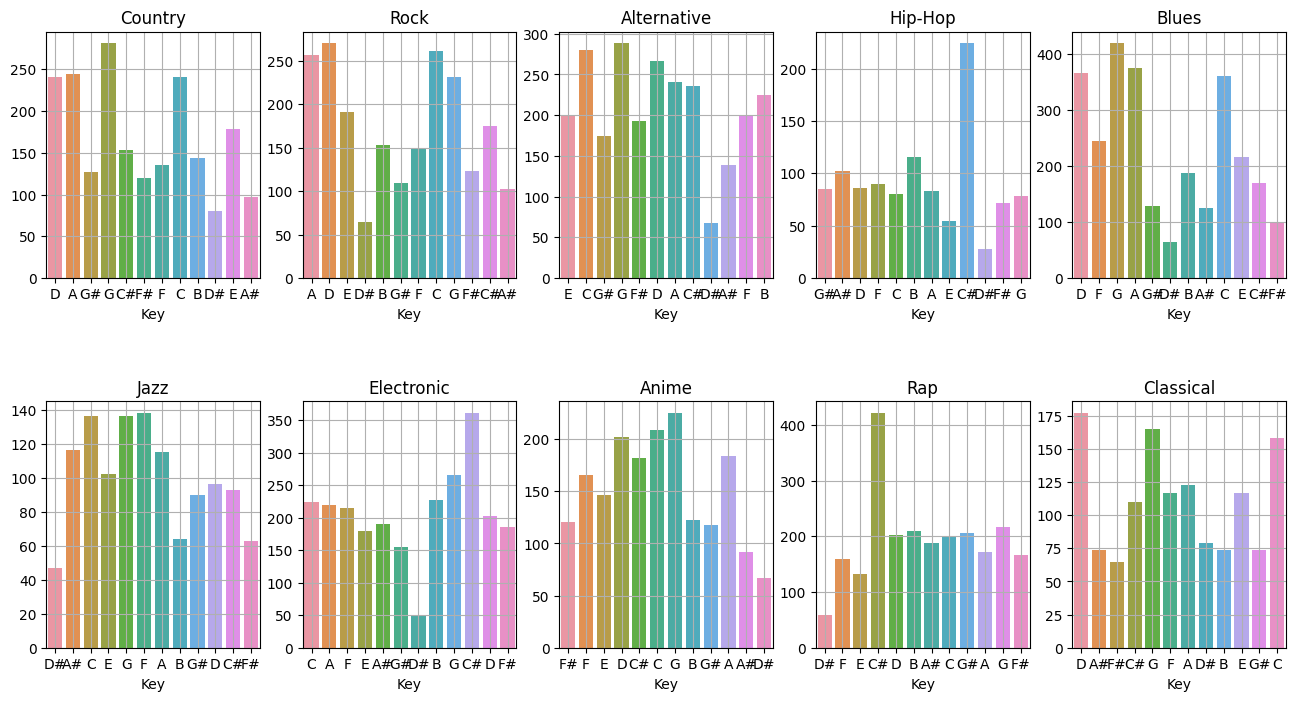

In [21]:
# Уникальные жанры в датасете
unique_genres = train_data['music_genre'].unique()

# Рассчитываем количество строк и столбцов для графиков
num_rows = len(unique_genres) // 5 + (len(unique_genres) % 5 > 0)
num_cols = min(len(unique_genres), 5)

# Создаем сетку для графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

# Создаем бар-графики для столбца 'key' для каждого жанра
for i, genre in enumerate(unique_genres):
    row, col = i // num_cols, i % num_cols
    ax = axes[row, col]
    subset = train_data[train_data['music_genre'] == genre]
    sns.countplot(data=subset, x='key', ax=ax)
    ax.set_title(f'{genre}')
    ax.set_xlabel('Key')
    ax.set_ylabel('')
    ax.grid(True)

plt.show()

Распределение на всех гистограммах по типу гребня. Определить жанр по базовому ключу практически невозможно. Можно выделить рэп и хип-хоп для которых наиболее характерным является базовый ключ С#, что опять указывает на очень сильное сходство между двумя этими жанрами. Для всех жанров свойственно более частое использование ключей A, G, C, D. Ключ D#, наоборот, практически не используется.

Теперь визуализируем значения в столбце mode по жанрам:

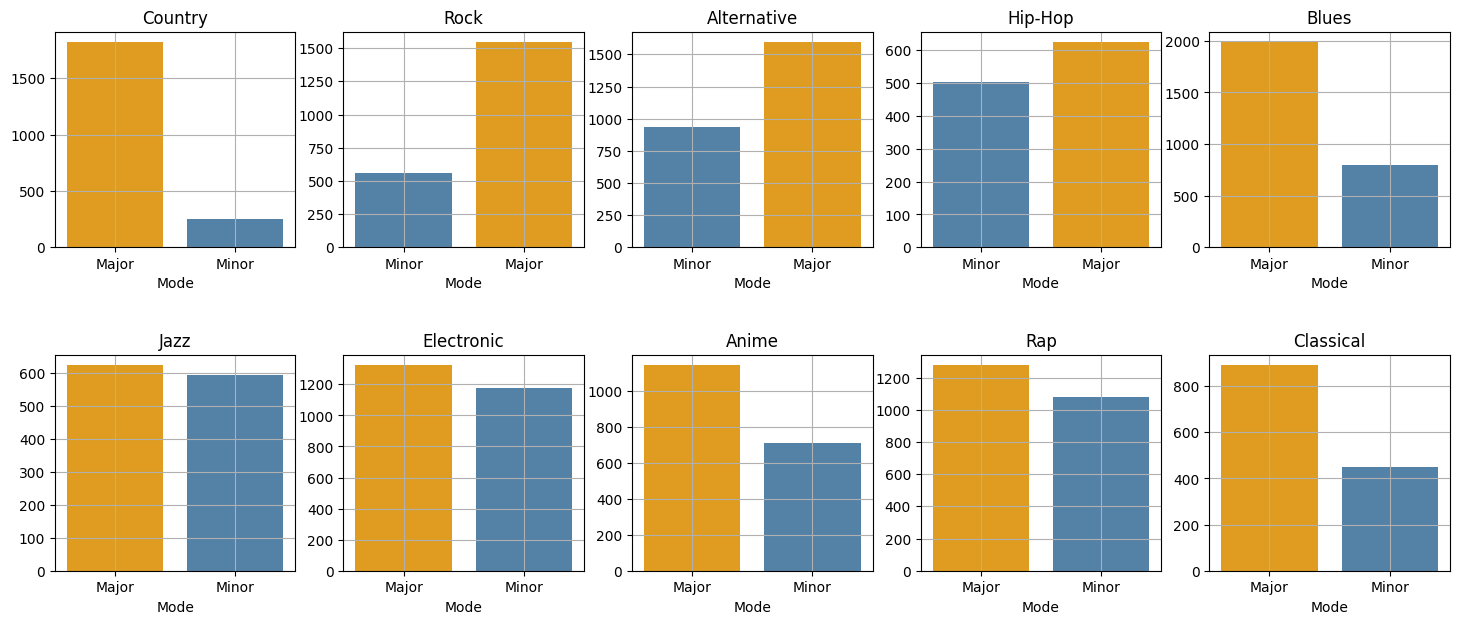

In [22]:
# Создаем сетку для графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 7))
fig.subplots_adjust(hspace=0.5)

# Определите цвета для "Major" и "Minor"
colors = {"Major": "#FFA500", "Minor": "#4682B4"}

# Создаем столбчатые диаграммы для столбца 'mode' для каждого жанра
for i, genre in enumerate(unique_genres):
    row, col = i // num_cols, i % num_cols
    ax = axes[row, col]
    subset = train_data[train_data['music_genre'] == genre]
    sns.countplot(data=subset, x='mode', ax=ax, palette=colors)
    ax.set_title(f'{genre}')
    ax.set_xlabel('Mode')
    ax.set_ylabel('')
    ax.grid(True)

plt.show()


Модальность является более надежным признаком для определения жанра, чем базовый ключ. Мы видим, что таким жанрам, как классика, рок, блюз и кантри свойственна мажорная модальность, особенно выделяется кантри, в которой практически отсутствует минор. Но к сожалению, некоторые жанры схожи между собой, например джаз и электроника, анимэ и альтернатива, а также рэп и хип-хоп. Жанр, где бы преобладали минорные ноты, отсутствует, но для джаза и электроники минорная модальность встречается почти в половине случаев.

Осталось посмотреть на дату загрузки в сервис:

In [23]:
unique_dates = train_data['obtained_date'].unique()

Уникальные значения:

In [24]:
unique_dates

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

Всего в датасете 4 даты загрузки, логично предположить, что эти даты не могут влиять на музыкальный жанр, поэтому их стоит удалить.

## Анализ названий треков

У нас есть столбец с названием треков, он может оказаться для очень важным. Посмотрим какие слова чаще всего встречаются в названиях треков по жанрам, для этого сначала выполним предобработку текста:

In [25]:
# Функция для предобработки текста в названиях треков
def preprocess_text(text):
    text = re.sub(r'\([^)]*\)', '', text) # удаляем скобки и их содержимое
    text = re.sub(r'[^a-zA-Z\s]', '', text) # удаляем специальные символы и цифры
    text = ' '.join([word for word in text.split() if len(word) > 1]) # удаляем слова, состоящие только из одной буквы
    return text

Посмотрим на результат:

In [26]:
train_data_for_text = train_data.copy()

In [27]:
train_data_for_text['processed_track_name'] = train_data_for_text['track_name'].apply(preprocess_text) # применим функцию

In [28]:
print(train_data_for_text[['track_name', 'processed_track_name']])

                       track_name      processed_track_name
0                      Highwayman                Highwayman
1           Toes Across The Floor     Toes Across The Floor
2           First Person on Earth     First Person on Earth
3      No Te Veo - Digital Single  No Te Veo Digital Single
4                 Chasing Shadows           Chasing Shadows
...                           ...                       ...
20389                      O Pato                      Pato
20390              Mt. Washington             Mt Washington
20391          Original Prankster        Original Prankster
20392                       4Peat                      Peat
20393   Trouble (feat. MC Spyder)                   Trouble

[20393 rows x 2 columns]


Текст обработан успешно. Посмотрим на 10 самых встречающихся слов по жанрам:

In [29]:
genre_keywords = {} #создаем словарь для хранения ключевых слов по жанрам

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # список стоп-слов на английском языке

for genre in train_data_for_text['music_genre'].unique():
    genre_data = train_data_for_text[train_data_for_text['music_genre'] == genre]
    track_names = genre_data['processed_track_name'].str.lower().str.split()
    words = [word for track in track_names for word in track if word not in stop_words]
    word_counts = Counter(words)
    genre_keywords[genre] = [word for word, count in word_counts.most_common(10)] # выбираем 10 наиболее часто встречающихся слов

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Выполним визуализацию по типу облака слов:

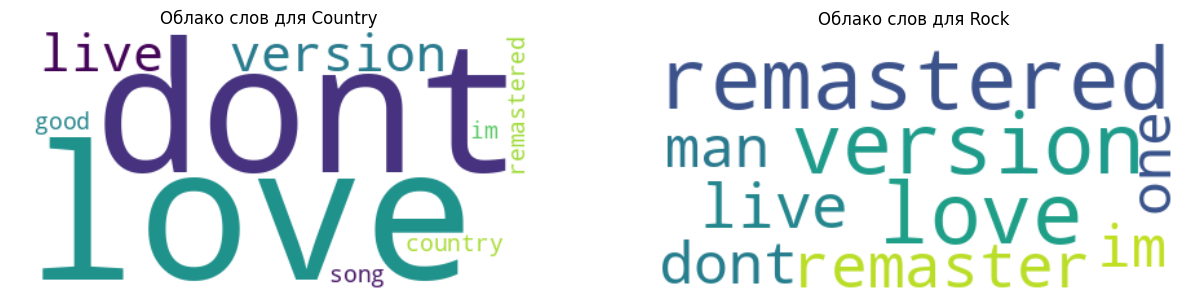

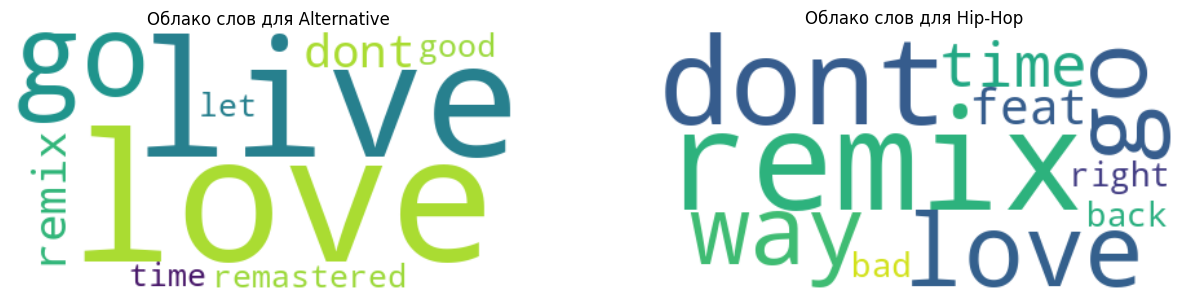

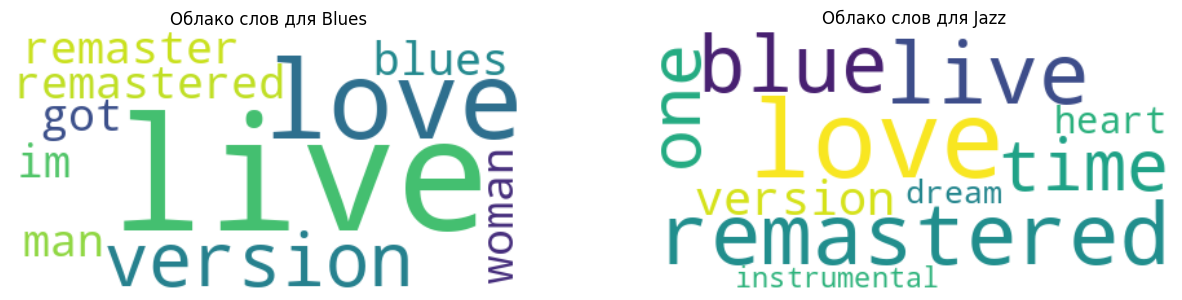

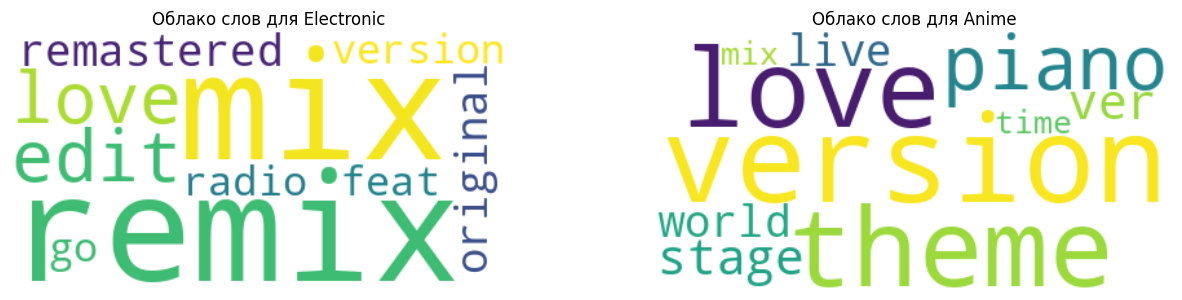

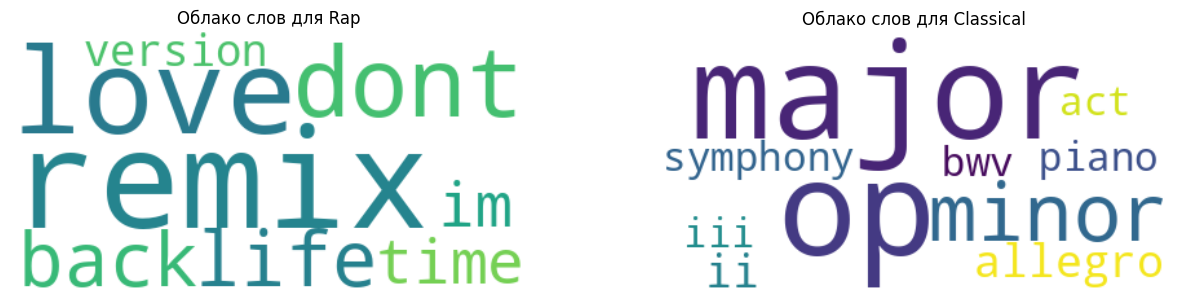

In [30]:
# создаем список жанров
genres = list(genre_keywords.keys())

# разобьем список жанров на строки по два жанра в каждой строке
rows = [genres[i:i+2] for i in range(0, len(genres), 2)]
for row in rows:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for genre, ax in zip(row, axs):
        keywords = genre_keywords[genre]
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(" ".join(keywords))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Облако слов для {genre}')
        ax.axis("off")

    plt.subplots_adjust(wspace=0.25)
    plt.show()


Большинство слов, например любовь и feat встречаются почти в каждом жанре. Уникальной является только классическая музыка. Так как этот жанр наиболее разнообразен по своему звучанию, возможно именно ключевые слова помогут в индентификации этого жанра.

In [31]:
# создаем словарь для отслеживания количества вхождений слов в жанры
word_counts = defaultdict(int)

# подсчитаем количество вхождений каждого слова в жанры
for genre_keywords_list in genre_keywords.values():
    for keyword in genre_keywords_list:
        word_counts[keyword] += 1

# порог для удаления слов
threshold = 2

# удаляем слова, которые встречаются более чем в двух жанрах
for genre, keywords_list in genre_keywords.items():
    genre_keywords[genre] = [keyword for keyword in keywords_list if word_counts[keyword] <= threshold]


Обновленный словарь с ключевыми словами:

In [32]:
for genre, keywords in genre_keywords.items():
    print(f'Жанр: {genre}')
    print(f'Ключевые слова: {", ".join(keywords)}')
    print()

Жанр: Country
Ключевые слова: country, good, song

Жанр: Rock
Ключевые слова: remaster, man, one

Жанр: Alternative
Ключевые слова: let, good

Жанр: Hip-Hop
Ключевые слова: way, feat, right, back, bad

Жанр: Blues
Ключевые слова: blues, remaster, man, woman, got

Жанр: Jazz
Ключевые слова: blue, one, heart, dream, instrumental

Жанр: Electronic
Ключевые слова: mix, edit, original, radio, feat

Жанр: Anime
Ключевые слова: theme, piano, stage, ver, world, mix

Жанр: Rap
Ключевые слова: life, back, get

Жанр: Classical
Ключевые слова: op, major, minor, allegro, ii, symphony, piano, act, iii, bwv



## Анализ корреляции в данных

Вычислим корреляционную матрицу с использованием библиотеки phik:

In [33]:
correlation_matrix = train_data.phik_matrix()

interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable track_name is large: 18642. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.
  warnings.warn(


Визуализируем тепловую карту:

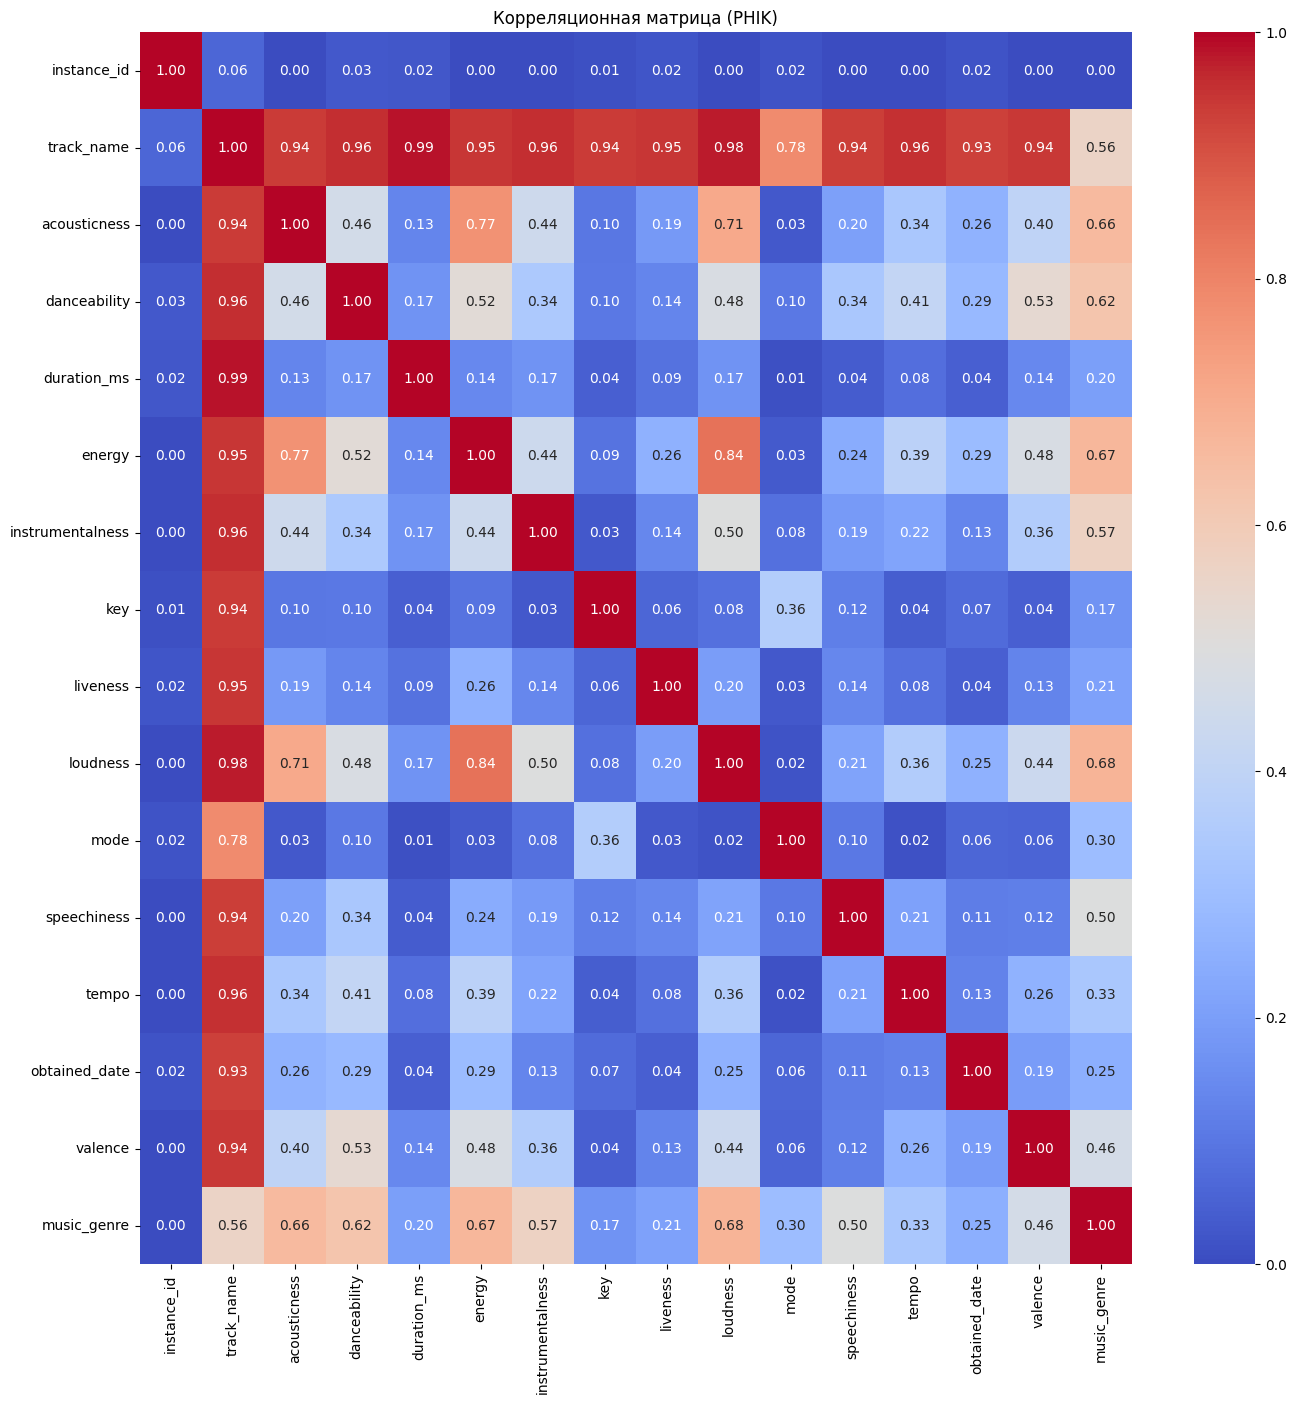

In [34]:
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица (PHIK)")
plt.show()

Обнаружена мультиколлинеарность в данных. Названия треков имеют высокую взаимосвязь (почти 1) с другими признаками. В дальнейшем стоит удалить этот столбец, взяв из него необходимую информацию для этапа моделирования.

С id трека связь других признаков наоборот отсутствует и равна нулю. Следует также удалить этот признак.

Между собой связаны следующие признаки: энергичность и громкость, акустичность и громкость, акустичность и энергичность.

Также тепловая карта показала, что на жанр в первую очередь влияет громкость, энергичность, акустичность и танцевальность. Чуть слабее влияет инструментальность и выразительность, привлекательность для пользователя.

Слабое влияние на жанр оказывает длительность трека, модальность, темп, живучесть и дата загрузки. Практически не имеет связи с целевым признаком базовый ключ (попробуем в дальнейшем его удалить).

## Промежуточный вывод:

Проведен исследовательский анализ данных. Отметим основные этапы:

- в данных есть пропущенные значения - как категориальные, так и числовые признаки. Удалять их не стоит, попробуем различные методы заполнения этих пропусков на этапе построения гипотез и моделирования.

- в данных есть аномальные значения (выбросы). Они обнаружены в столбце - длительность трека. Во-первых, следует заменить все отрицательные значение - на медианные по жанру, во-вторых, стоит попробовать удалить все треки более 5 минут. Остальные шумы в данных не трогаем, так как они могут указывать на уникальность трека и также могут быть полезны при обучении.

- При анализе категориальных переменных была выявлена низкая взаимосвязь между датой загрузки, базовым ключом и музыкальным жанром. Попробуем удалить эти признаки на этапе моделирования.

- Выявлена мультиколлинеарность в данных, а именно название трека имеет очень высокую взаимосвязь с целевым признаком. Столбец с названием трека подлежит удалению.

- Связь между id трека и его музыкальным жанров полностью отсутствует, этот признак подлежит удалению.

- Также выявлены признаки, между которыми очень тесная связь, можно попробовать добавить среднее значение этих признаков как дополнительный признак.

- Составлен список ключевых слов, характерных для определенного жанра, на этом основании можно создать новые признаки.

# Моделирование и генерация новых признаков

Создадим копию нашего обучающего датафрейма, чтоб всегда можно было вернуться к первоночальным данным:

In [35]:
copy_train_data = train_data.copy()

## Первичная предобработка данных

Удалим столбцы, отмеченные на этапе исследования, заполним пропуски в данных, а также преобразует категориальные данные в числовые:

In [36]:
train_data.drop(['track_name', 'key', 'instance_id', 'obtained_date'], axis=1, inplace=True)

Разделим  набор данных на числовые и категориальные признаки:

In [37]:
numeric_features = train_data.select_dtypes(include=['number'])
categorical_features = train_data.select_dtypes(include=['object'])

Создадим объекты IterativeImputer и SimpleImputer с соответствующими параметрами для заполнения пропусков

In [38]:
numeric_imputer = IterativeImputer(max_iter=10, random_state=0)
categorical_imputer = SimpleImputer(strategy="most_frequent")

In [39]:
numeric_filled = numeric_imputer.fit_transform(numeric_features)
categorical_filled = categorical_imputer.fit_transform(categorical_features)

Преобразуем полученные массивы обратно в DataFrame и объединим их:

In [40]:
numeric_filled_df = pd.DataFrame(numeric_filled, columns=numeric_features.columns)
categorical_filled_df = pd.DataFrame(categorical_filled, columns=categorical_features.columns)

train_data = pd.concat([numeric_filled_df, categorical_filled_df], axis=1)

In [41]:
train_data.isnull().sum().sum()

0

Закодируем категориальные признаки, кроме музыкального жанра:

In [42]:
categorical_features = categorical_features.drop(columns=['music_genre'])

# Применяем One-Hot Encoding к оставшимся категориальным признакам
train_data = pd.get_dummies(train_data, columns=categorical_features.columns)


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20393 entries, 0 to 20392
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20393 non-null  float64
 1   danceability      20393 non-null  float64
 2   duration_ms       20393 non-null  float64
 3   energy            20393 non-null  float64
 4   instrumentalness  20393 non-null  float64
 5   liveness          20393 non-null  float64
 6   loudness          20393 non-null  float64
 7   speechiness       20393 non-null  float64
 8   tempo             20393 non-null  float64
 9   valence           20393 non-null  float64
 10  music_genre       20393 non-null  object 
 11  mode_Major        20393 non-null  uint8  
 12  mode_Minor        20393 non-null  uint8  
dtypes: float64(10), object(1), uint8(2)
memory usage: 1.8+ MB


## Разделение на фичи и целевой признак:

Также создадим функцию для разделения данных:

In [44]:
def split_and_encode_data(train_data, target_column, test_size=0.1):
    # Отделяем целевой столбец
    X = train_data.drop(target_column, axis=1)
    y = train_data[target_column]

    # Разделяем данные на обучающий и валидационный наборы
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    X_train, X_valid, y_train, y_valid = iterative_train_test_split(X.values, y_encoded, test_size=test_size)

    return X_train, X_valid, y_train, y_valid, encoder

Используем функцию на базовом датасете:

In [45]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(train_data, target_column='music_genre', test_size=0.1)

In [46]:
X_train.shape

(18353, 12)

In [47]:
X_valid.shape

(2040, 12)

## Оценка модели после первичной предобработки:

Используем для оценки следующие модели - логистическая регрессия, деревья решений, кэтбуст:

In [48]:
def train_and_evaluate_models(X_train, y_train, X_valid, y_valid):
    # Примените стандартизацию к обучающим данным
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Примените ту же стандартизацию к валидационным данным
    X_valid_scaled = scaler.transform(X_valid)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'CatBoost': CatBoostClassifier(verbose=False)
    }

    results = {}
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_valid_scaled)
        accuracy = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred, average='weighted')

        # Для ROC-AUC требуется вероятностный прогноз
        if model_name == 'CatBoost':
            y_proba = model.predict_proba(X_valid_scaled)
            roc_auc = roc_auc_score(y_valid, y_proba, multi_class='ovr')
        else:
            roc_auc = None

        results[model_name] = {
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC-AUC': roc_auc
        }

    # Преобразование словаря results в DataFrame
    results_df = pd.DataFrame(results).T
    return results_df

Используем функцию для обучения и посмотрим на рузультат:

In [49]:
experiment_1 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_1)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.400000  0.363574       NaN
Decision Tree        0.298529  0.297181       NaN
CatBoost             0.456373  0.434340  0.864592


Дерево решений показало  худший результат, модель может правильно предсказать только 30% данных. Логистическая регрессия сработала лучше, верно предсказано 40% данных, но этот результат неудовлетворителен. Лучше всех справился кэтбуст, он верно идентифицировал более 46% данных, но к сожалению это тоже плохой результат.

## Очищенный признак - длительность трека

В столбце - длительность трека - было обнаружено несколько аномалий, а именно - отрицательные значения и очень длинные треки. Было предложено заменить отрицательные значения на медианные и удалить треки более 5 минут, но все таки, чтобы сохранить данные, попробуем удалить треки более 7 минут.

In [50]:
# Создаем словарь с медианными значениями duration_ms для каждого жанра
median_duration_ms_by_genre = train_data.groupby('music_genre')['duration_ms'].median().to_dict()

# Заменяем отрицательные значения duration_ms на медианные значения по жанрам
train_data['duration_ms'] = train_data.apply(
    lambda row: median_duration_ms_by_genre[row['music_genre']] if row['duration_ms'] < 0 else row['duration_ms'],
    axis=1)

In [51]:
# Фильтруем строки, где значение в столбце 'duration_ms' больше 7 минут
train_data = train_data[train_data['duration_ms'] <= 420000.0]

Посмотрим, как удаление аномалий изменило наши метрики:

In [52]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(train_data, target_column='music_genre', test_size=0.1)

In [53]:
experiment_2 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_2)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.398469  0.360705       NaN
Decision Tree        0.332143  0.333984       NaN
CatBoost             0.523980  0.508783  0.887591


Для логистической регрессии метрика ухудшилась, а вот для деревьев решений и кэтбуста удаление выбросов в столбце - длительность трека, наоборот, мерику улучшило.

## Генерация новых признаков:

### Ключевые слова:

Посмотрим, как метрики изменятся после добавления в датасет сведений о наиболее часто встречающихся в названии треков словах, распределенных по жанрам:

Восстановим данные с названиями треков:

In [54]:
keywords_train_data = copy_train_data.copy()

In [55]:
keywords_train_data['track_name'] = keywords_train_data['track_name'].apply(preprocess_text) # очистим текст от ненужных символов

In [56]:
# Добавление бинарных признаков для каждого ключевого слова
for genre, keywords in genre_keywords.items():
    for keyword in keywords:
        # Создание бинарного признака для каждого ключевого слова
        keywords_train_data[f'{keyword}_in_track_name'] = keywords_train_data['track_name'].str.lower().str.contains(keyword).astype(int)

Повторим все шаги, указанные выше:

In [57]:
columns_to_drop = ['track_name', 'key', 'instance_id', 'obtained_date']
keywords_train_data.drop(columns=columns_to_drop, axis=1, inplace=True)

In [58]:
numeric_features = keywords_train_data.select_dtypes(include=['number'])
categorical_features = keywords_train_data.select_dtypes(include=['object'])

In [59]:
numeric_imputer = IterativeImputer(max_iter=10, random_state=0)
categorical_imputer = SimpleImputer(strategy="most_frequent")

In [60]:
numeric_filled = numeric_imputer.fit_transform(numeric_features)
categorical_filled = categorical_imputer.fit_transform(categorical_features)

In [61]:
numeric_filled_df = pd.DataFrame(numeric_filled, columns=numeric_features.columns)
categorical_filled_df = pd.DataFrame(categorical_filled, columns=categorical_features.columns)

keywords_train_data = pd.concat([numeric_filled_df, categorical_filled_df], axis=1)

Применяем One-Hot Encoding к категориальным признакам:

In [62]:
categorical_features = categorical_features.drop(columns=['music_genre'])
keywords_train_data = pd.get_dummies(keywords_train_data, columns=categorical_features.columns)

In [63]:
keywords_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20393 entries, 0 to 20392
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   acousticness                20393 non-null  float64
 1   danceability                20393 non-null  float64
 2   duration_ms                 20393 non-null  float64
 3   energy                      20393 non-null  float64
 4   instrumentalness            20393 non-null  float64
 5   liveness                    20393 non-null  float64
 6   loudness                    20393 non-null  float64
 7   speechiness                 20393 non-null  float64
 8   tempo                       20393 non-null  float64
 9   valence                     20393 non-null  float64
 10  country_in_track_name       20393 non-null  float64
 11  good_in_track_name          20393 non-null  float64
 12  song_in_track_name          20393 non-null  float64
 13  remaster_in_track_name      203

Удалим аномалии:

In [64]:
# Создаем словарь с медианными значениями duration_ms для каждого жанра
median_duration_ms_by_genre = keywords_train_data.groupby('music_genre')['duration_ms'].median().to_dict()

# Заменяем отрицательные значения duration_ms на медианные значения по жанрам
train_data['duration_ms'] = keywords_train_data.apply(
    lambda row: median_duration_ms_by_genre[row['music_genre']] if row['duration_ms'] < 0 else row['duration_ms'],
    axis=1)

In [65]:
# Фильтруем строки, где значение в столбце 'duration_ms' больше 7 минут
keywords_train_data = keywords_train_data[keywords_train_data['duration_ms'] <= 420000.0]

In [66]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(keywords_train_data, target_column='music_genre', test_size=0.1)

In [67]:
experiment_3 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_3)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.402551  0.378602       NaN
Decision Tree        0.317857  0.319307       NaN
CatBoost             0.472449  0.450903  0.866249


Метрика ухудшилась, ключевые слова не помогли. Вернемся к первоначальной таблице train_data и попробуем кластеризацию.

### Кластеризация:

Определим список признаков, которые будем использовать для кластеризации:

In [68]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'valence', 'speechiness']

Создадим функцию для кластрезации (с ее помощью можно провести ряд эксперементов, добавить или удалить признаки для создания кластеров, выбрать необходимое количество кластеров):

In [69]:
def cluster_data(data, features, n_clusters):
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X) # стандартизация признаков, так как алгоритм чувствителен к масштабам признаков
    kmeans = KMeans(n_clusters=n_clusters) # создаем модель K-Means
    kmeans.fit(X_scaled)
    data['cluster'] = kmeans.labels_

    return data

In [70]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19597 entries, 0 to 20392
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      19597 non-null  float64
 1   danceability      19597 non-null  float64
 2   duration_ms       19597 non-null  float64
 3   energy            19597 non-null  float64
 4   instrumentalness  19597 non-null  float64
 5   liveness          19597 non-null  float64
 6   loudness          19597 non-null  float64
 7   speechiness       19597 non-null  float64
 8   tempo             19597 non-null  float64
 9   valence           19597 non-null  float64
 10  music_genre       19597 non-null  object 
 11  mode_Major        19597 non-null  uint8  
 12  mode_Minor        19597 non-null  uint8  
dtypes: float64(10), object(1), uint8(2)
memory usage: 1.8+ MB


Попробуем 10 кластеров, так как у нас 10 музыкальных жанров.

In [71]:
cluster_10_train_data = cluster_data(train_data, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'valence', 'speechiness'], n_clusters=10)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(cluster_10_train_data, target_column='music_genre', test_size=0.1)

In [73]:
experiment_4 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_4)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.386224  0.351236       NaN
Decision Tree        0.332653  0.333386       NaN
CatBoost             0.498980  0.480403  0.883654


Улучшение только для деревьев решений, для остальных моделей метрика f1 упала. Можно попробовать провести эксперементы с 2 и 5 кластерами:

In [74]:
cluster_2_train_data = cluster_data(train_data, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'valence', 'speechiness'], n_clusters=2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [75]:
cluster_5_train_data = cluster_data(train_data, ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'valence', 'speechiness'], n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [76]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(cluster_2_train_data, target_column='music_genre', test_size=0.1)

In [77]:
experiment_5 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_5)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.377041  0.342866       NaN
Decision Tree        0.334694  0.335660       NaN
CatBoost             0.500510  0.484836  0.882595


In [78]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(cluster_5_train_data, target_column='music_genre', test_size=0.1)

In [79]:
experiment_6 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_6)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.401020  0.367809       NaN
Decision Tree        0.354592  0.354036       NaN
CatBoost             0.505612  0.488243  0.888881


По итогам эксперемента кластеризация на 10 кластеров не дала ожидаемых результатов, метрика у кэтбуста и логистической регрессии упала, для случайного леса есть небольшие улучшения, но это не значительно. Можно ометить, что при определении двух кластеров результат f1 наибольший.

In [80]:
train_data.drop('cluster', axis=1, inplace = True)

### Дополнительные признаки:

Попробуем новые признаки на основе имеющихся:

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19597 entries, 0 to 20392
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      19597 non-null  float64
 1   danceability      19597 non-null  float64
 2   duration_ms       19597 non-null  float64
 3   energy            19597 non-null  float64
 4   instrumentalness  19597 non-null  float64
 5   liveness          19597 non-null  float64
 6   loudness          19597 non-null  float64
 7   speechiness       19597 non-null  float64
 8   tempo             19597 non-null  float64
 9   valence           19597 non-null  float64
 10  music_genre       19597 non-null  object 
 11  mode_Major        19597 non-null  uint8  
 12  mode_Minor        19597 non-null  uint8  
dtypes: float64(10), object(1), uint8(2)
memory usage: 1.8+ MB


Удалим кластеры:

In [82]:
train_data['1_feature'] = train_data['acousticness']+train_data['instrumentalness']+train_data['speechiness']

In [83]:
train_data['2_feature'] = train_data['danceability']+train_data['energy']+train_data['tempo']

In [84]:
train_data['3_feature'] = train_data['loudness']+train_data['valence']

In [85]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(train_data, target_column='music_genre', test_size=0.1)

In [86]:
experiment_7 = train_and_evaluate_models(X_train, y_train, X_valid, y_valid)
print(experiment_7)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression  0.393878  0.358347       NaN
Decision Tree        0.312245  0.311583       NaN
CatBoost             0.515816  0.497569  0.889823


Новые признаки заметных улучшений не дали, удалим их, чтоб не получить переобучение модели.

In [87]:
train_data.drop(['1_feature', '2_feature', '3_feature'],axis=1, inplace = True)

## Промежуточный вывод:

Данные были предварительно обработаны - удалены столбцы, отмеченные в исследовательском анализе, заполнены пропуски в данных, а также отрицательные значения в столбце - длительность трека - заменены на медианные значения по жанру и удалены треки более 7 минут. Категориальные признаки закодированы с помощью OHE.

В процессе обучения было использовано три модели - логическая регрессия, деревья решений и кэтбуст.

Проведен ряд экспериментов, в ходе которых были сгенерированы новые признаки - ключевые слова, кластеры, и дополнительные фичи на основе имеющихся, к сожалению ничего из этого не дало положительного результата в увеличение метрики.

Лучшей моделью по итогу эксперимента оказался кэтбуст, его метрика f1 близка к 0,5.

# Итоговая модель и настройка гиперпараметров

На основе этапа моделирования выбрана лучшая модель - кэтбуст. Настроим гиперпараметры этой модели:

In [88]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 100),
        "border_count": trial.suggest_int("border_count", 5, 255),
        "thread_count": -1,
        "verbose": 0,
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=params["verbose"])

    y_pred = model.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average="weighted")

    return f1

In [89]:
X_train, y_train, X_valid, y_valid, encoder = split_and_encode_data(train_data, target_column='music_genre', test_size=0.1)

In [90]:
X_train.shape

(17637, 12)

In [91]:
X_valid.shape

(1960, 12)

Создание и запуск оптимизации:

In [92]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=15)

#best_params = study.best_params
#best_f1 = study.best_value

#print("Лучшие параметры:", best_params)
#print("Лучшее F1:", best_f1)

Обучаем модель:

In [93]:
model = CatBoostClassifier(iterations = 834, depth = 8, learning_rate = 0.0840224653770045,
                           l2_leaf_reg = 86.2590299562076, border_count = 161,
                           thread_count = -1, verbose = 0,
                           loss_function = "MultiClass", eval_metric = "MultiClass")

In [94]:
model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
         )

# Тестирование модели

Обрабатываем тестовые данные:

In [95]:
def pres(data):

  columns_to_drop = ['track_name', 'instance_id', 'obtained_date']
  data.drop(columns=columns_to_drop, axis=1, inplace=True)

  numeric_features = data.select_dtypes(include=['number'])
  categorical_features = data.select_dtypes(include=['object'])

  numeric_imputer = IterativeImputer(max_iter=10, random_state=0)
  categorical_imputer = SimpleImputer(strategy="most_frequent")

  numeric_filled = numeric_imputer.fit_transform(numeric_features)
  categorical_filled = categorical_imputer.fit_transform(categorical_features)

  numeric_filled_df = pd.DataFrame(numeric_filled, columns=numeric_features.columns)
  categorical_filled_df = pd.DataFrame(categorical_filled, columns=categorical_features.columns)

  data = pd.concat([numeric_filled_df, categorical_filled_df], axis=1)

  data = pd.get_dummies(data, columns=categorical_features.columns)

  return data

Перед обработкой сохраним индексы:

In [96]:
instance_ids = test_data['instance_id']

Применим функцию первичной обработки:

In [97]:
pres_test_data = pres(test_data)

Получаем предсказания модели:

In [98]:
y_pred_test = model.predict(pres_test_data)

In [99]:
y_pred_test.shape

(5099, 1)

Выполним раскодировку предсказанных жанров:

In [100]:
y_pred_decoded = encoder.inverse_transform(y_pred_test)

In [101]:
predictions = pd.DataFrame({'instance_id': instance_ids, 'music_genre':y_pred_decoded.ravel()})

In [102]:
predictions

,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


Сохраним предсказания в необходимом формате:

In [103]:
predictions.to_csv('sample_submit.csv', index=False)

# Oшибки модели

## Важность признаков

In [104]:
col = train_data.drop('music_genre', axis = 1)

In [105]:
feature_importance = model.get_feature_importance()

importance_series = pd.Series(feature_importance, index=col.columns)
importance_series = importance_series.sort_values(ascending=False)

print(importance_series)

instrumentalness    17.104885
speechiness         15.216791
danceability        14.566561
duration_ms         10.968760
acousticness         9.545180
valence              9.407891
loudness             7.472535
energy               6.738380
tempo                4.068252
liveness             2.519563
mode_Major           1.814872
mode_Minor           0.576329
dtype: float64


Сделаем оценку важности признаков более наглядной:

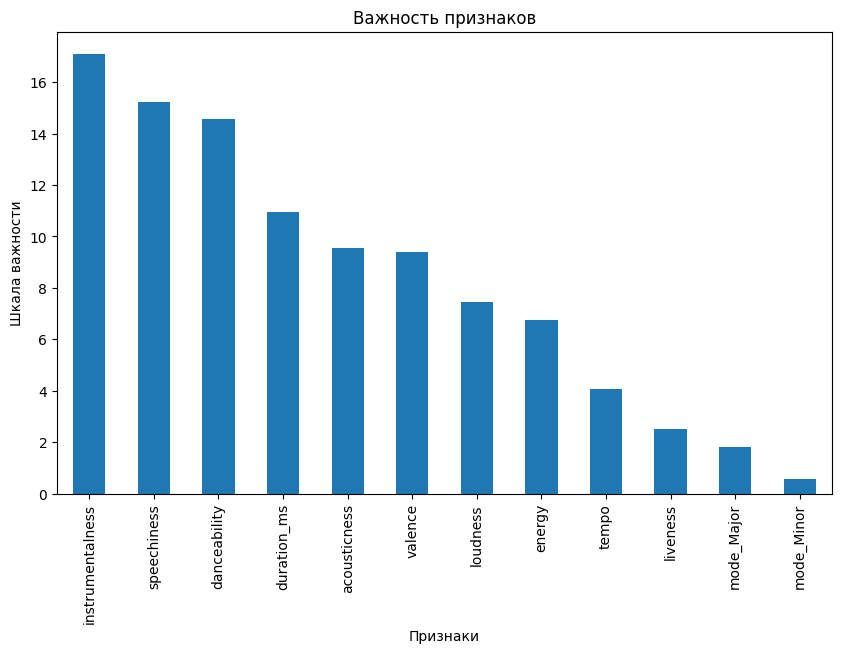

In [106]:
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar')
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Шкала важности')
plt.show()

Самым важным признаком в модели является инструментальность, выразительность и танцевальность. Интересно, что при анализе кореляции признаков наибольшая взаимосвязь с жанром была у акустики, громкости и энергии, в модели эти признаки оказались незначительными. Модальность модель считает самым незначительным признаком.

## Матрица ошибок

In [107]:
y_pred = model.predict(X_valid)

In [108]:
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5188775510204081


In [109]:
y_pred_decoded = encoder.inverse_transform(y_pred)

In [110]:
y_valid_decoded = encoder.inverse_transform(y_valid)

In [111]:
confusion = confusion_matrix(y_valid_decoded, y_pred_decoded)

# Вывод матрицы ошибок
print("Confusion Matrix:")
print(confusion)

# Вычисление отчета о классификации (Classification Report)
report = classification_report(y_valid_decoded, y_pred_decoded)

# Вывод отчета о классификации
print("Classification Report:")
print(report)


Confusion Matrix:
[[106  22  35   1  23  27   1   4  27  11]
 [ 11 101  11  22  14   9   0   5   1   6]
 [ 19  18 159   4  30  12   0   5   9   8]
 [  0   6   3  81   0   0   0   3   0   0]
 [ 14  15  25   0 131   2   1   1  22  16]
 [ 15  10  26   2   2 154   1  15  15   7]
 [  6   2   3   0   1   7  13   0  87   0]
 [  2   6  32  10   1  19   1  38   7   4]
 [ 11   2   3   0   9  11   8   0 192   1]
 [ 34  21  47   1  44  14   0   4   9  42]]
Classification Report:
              precision    recall  f1-score   support

 Alternative       0.49      0.41      0.45       257
       Anime       0.50      0.56      0.53       180
       Blues       0.46      0.60      0.52       264
   Classical       0.67      0.87      0.76        93
     Country       0.51      0.58      0.54       227
  Electronic       0.60      0.62      0.61       247
     Hip-Hop       0.52      0.11      0.18       119
        Jazz       0.51      0.32      0.39       120
         Rap       0.52      0.81      0.

Oбщая точность модели составляет 0.50, что означает, что 50% всех объектов были правильно классифицированы. Есть неравномерность в определении классов, так например метрики для классики самые высокие, модель справилась неплохо, а вот с хип-хопом и роком модель справилась хуже всего.

К сожалению в ходе исследования не удалось найти необходимые признаки, которые бы смогли значительно повлиять на результаты правильного определения класса. На данный момент модель не справилась с поставленной задачей.

## Константная модель

Создаем константную модель:

In [112]:
constant_model = DummyClassifier(strategy="most_frequent")
constant_model.fit(X_train, y_train)
predictions = constant_model.predict(X_valid)

accuracy = (predictions == y_valid).mean()
print("Accuracy:", accuracy)

Accuracy: 0.1346938775510204


Константная модель может правильно индентифицировать только 13% данных, что делает полученную в ходе исследования модель более производительной.

## Визуализация музыкальных жанров с помощью РСА

Выполним визуализацию данных и оценим, как жанры распределены в пространстве признаков, используя метод снижения размерности PCA. Спроецируем данные на трехмерную плоскость:

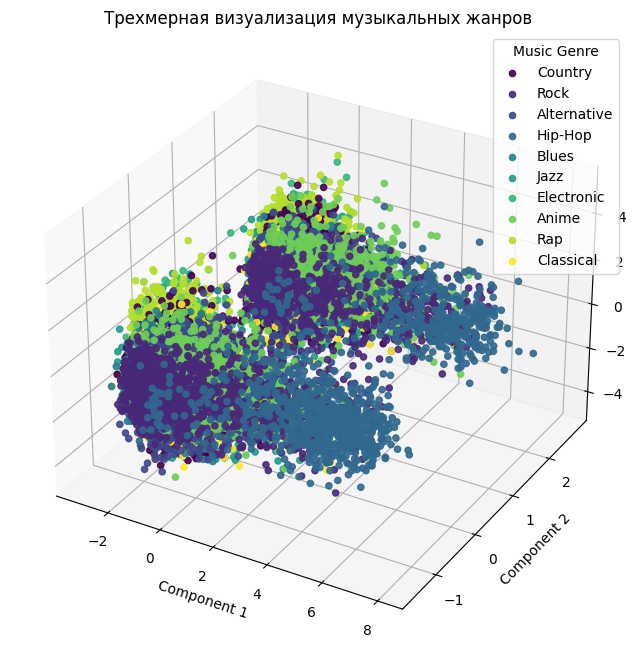

In [113]:
# повторяем действия по разделению и стандартизации данных
X = train_data.drop(columns=['music_genre'])
y = train_data['music_genre']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# применяем метод главных компонент (PCA) для снижения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Создаем DataFrame для визуализации
df_pca = pd.DataFrame(data=X_pca, columns=['Component 1', 'Component 2', 'Component 3'])
df_pca['music_genre_encoded'] = y_encoded

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
unique_genres = y.unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))

for i, genre in enumerate(unique_genres):
    genre_df = df_pca[df_pca['music_genre_encoded'] == i]
    ax.scatter(genre_df['Component 1'], genre_df['Component 2'], genre_df['Component 3'],
               label=genre, color=colors[i], alpha=0.9, s=20)
ax.set_title('Трехмерная визуализация музыкальных жанров')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend(title='Music Genre')

plt.show()

На этой визуализации очень хорошо видно, что данные разделены на два кластера, вот почему модели так трудно получить хорошую метрику. В этих кластерах все жанры перемешаны, четкого разделения между ними нет.

# Итоговый вывод:

- Цель проекта - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Представлены данные для обучения и тестирования модели.

- Обучающие данные были изучены, в ходе исследования выявлено, что жанры между собой имеют очень сильное сходство, например хип-хоп и рэп, рок и альтернатива. Так же в обучающих данных обнаружены пропуски, аномальные значения и мультиколлинеарность. Есть фичи, которые имеют низкую взаимосвязь с целевым признаком. На этапе исследования вынесены предложения по предобработке данных.

- На этапе предобработки удалены признаки - 'track_name', 'key', 'instance_id', 'obtained_date'.
Пропуски в числовых признаках заполнены с помощью IterativeImputer, а категориальные - с помощью SimpleImputer(strategy="most_frequent").
Далее категориальные признаки закодированы методом OHE.

- На этапе моделирования выбрано три модели - логистическая регрессия, деревья решений и кэтбуст. Был проведен ряд экспериментов:

1) первичная предобработка:

In [114]:
experiment_1

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.400000,0.363574,NaN
Decision Tree,0.298529,0.297181,NaN
CatBoost,0.456373,0.434340,0.864592


2) устранены аномалии из признака 'длительность трека' (отрицательные значения заполнены медианными, по музыкальному жанру):

In [115]:
experiment_2

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.398469,0.360705,NaN
Decision Tree,0.332143,0.333984,NaN
CatBoost,0.523980,0.508783,0.887591


3) Добавлены ключевые слова:

In [116]:
experiment_3

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.402551,0.378602,NaN
Decision Tree,0.317857,0.319307,NaN
CatBoost,0.472449,0.450903,0.866249


4) Кластеризация (на 10 кластеров по количеству жанров):

In [117]:
experiment_4

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.386224,0.351236,NaN
Decision Tree,0.332653,0.333386,NaN
CatBoost,0.498980,0.480403,0.883654


5) Дополнительные признаки на основе имеющихся:

In [118]:
experiment_7

,Accuracy,F1 Score,ROC-AUC
Logistic Regression,0.393878,0.358347,NaN
Decision Tree,0.312245,0.311583,NaN
CatBoost,0.515816,0.497569,0.889823


По результатам экспериментов было принято решение использовать модель - кэтбуст, при этом выполнить только первичную предобработку признаков и удалить аномалии из столбца - длительность трека. К сожалению генерация новых признаков не дала ожидаемых результатов, метрику улучшить не удалось.

- Были настроены гиперпараметры модели с помощью optuna, и построена модель model = CatBoostClassifier(iterations = 834, depth = 8, learning_rate = 0.0840224653770045, l2_leaf_reg = 86.2590299562076, border_count = 161, thread_count = -1, verbose = 0, loss_function = "MultiClass", eval_metric = "MultiClass")

- Представленные тестовые данные были также обработаны (удалены лишние столбцы, заполнены пропуски, выполнена кодировка признаков), в результате получены предсказания по музыкальным жанрам и сохранены в формате predictions.to_csv('sample_submit.csv', index=False).

- На этапе анализа и важности признаков были выявлены следующие моменты: наиболее важными для модели оказались не акустичность, энергичность и громкость, а инструментальность, выразительность и танцевальность. Инструментальность имеет четкий диапазон только для четырех жанров - джаз, классика, анимэ, электроника, но при этом джаз модель определила плохо (f1 = 0,38). Лучше всего модель справилась с классикой - f1 = 0,79 и рэпом - f1 = 0,63, хотя на этапе исследования были предположения, что именно эти жанры будут распознаваться тяжелее всего.

По итогу тестирования модель получила не лучшую оценку (f1=0.47), но с учетом, что константная модель может определить только 13% данных, результат является с точки зрения внедрения модели удовлетворительным.